In [4]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Defining the parameterized state

Let $U(\vec\theta)$ be the Qiskit RealAmplitudes circuit on two qubits

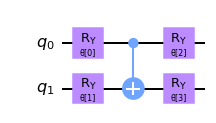

In [5]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw()

Defining a Hamiltonian

In [6]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

In [7]:
from qiskit.opflow import StateFn, PauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)
print(pauli_basis)

ComposedOp([
  OperatorMeasurement(ZZ),
  CircuitStateFn(
       ┌──────────┐     ┌──────────┐
  q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
       ├──────────┤┌─┴─┐├──────────┤
  q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
       └──────────┘└───┘└──────────┘
  )
])


In [8]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(pauli_basis, params=value_dict).eval()  
    return np.real(result)

To make things concrete, fix a point $\vec p$ and an index i and ask: What's the derivative of the expectation value with respect to parameter $\theta_i$ at point $\vec p$?

We choose a random point $\vec p$ and $i=2$.

In [9]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

## Finite difference gradients
Taking points a small distance $\epsilon$ before and after $\vec p$, and finding the gradient between them.

### Manually

In [11]:
eps = 0.2
# make identity vector with a 1 at index ``index``, otherwise 0
e_i = np.identity(point.size)[:, index]
print(e_i)

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)
print(finite_difference)

[0. 0. 1. 0.]
0.1312255859375


### Automatically using Qiskit's Gradient class

In [12]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


0.10742187499999978

## Analytic gradients
Using Parameter Shift rule to simplify

### Manually

In [13]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.14428710937499997


### Automatically using Qiskit's Gradient class

In [14]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

0.14172363281250006

## Optimizing the expectation value

In [15]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341]) # now fix and initial point for reproducibility

In [16]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

To compare the convergence of the optimizers, we can keep track of the loss at each step by using a callback function.

In [20]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_callback)

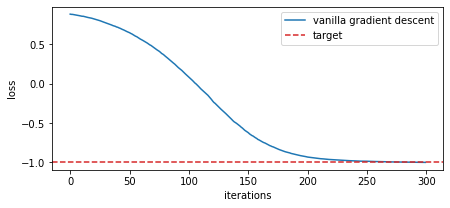

In [21]:
x_opt, fx_opt, nfevs = gd.optimize(
    initial_point.size,    # number of parameters
    evaluate_expectation,  # function to minimize
    gradient_function=evaluate_gradient,  # function to evaluate gradient
    initial_point=initial_point  # initial point
)

import matplotlib 
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()